# Задача восстановления регрессии #

Задачу обучения по прецедентам при Y = R принято называть задачей *восстановления регрессии*. Введём основные обозначения.

Задано пространство объектов $X$ и множество ответов $Y$. Мы предполагаем существование зависимости $y:X \rightarrow Y$, значения которой известны только на объектах обучающей выборки $X^n = (x_i, y_i)_{i=1}^n$.

Требуется построить алгоритм (&laquo;*функцию регрессии*&raquo;) $a: X \rightarrow Y$, аппроксимирующий целевую зависимость $y$.

- $X$ &mdash; объекты; $Y$ &mdash; ответы;
- $X^n = (x_i, y_i)_{i=1}^n$ &mdash; обучающая выборка;
- $y_i=y(x_i), y:X \rightarrow Y$ &mdash; неизвестная зависимость.

In [1]:
# Imports
import sys
import warnings
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps
import seaborn as sns

sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Styles, fonts
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 12

---

## Генерация данных ##

В качестве обучающих данных будем использовать зашумлённую линейную зависимость между $y$ и $x$.
Для выборки данных размером $n$ предполагаемая зависимость может быть смоделирована следующим образом:

$$ y_i = \theta_0 + \theta_1 x_i + \epsilon_i  \quad (i = 1, \ldots, n) $$

Здесь:
- $x_i$ &mdash; независимая (входная) переменная выборки $i$, с $x = \{x_i \ldots x_n \}$.
- $y_i$ &mdash; зависимая (выходная) переменная выборки $i$, с $y = \{y_i \ldots y_n \}$.
- $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ &mdash; нормальный шум, влияющий на выходной сигнал $y_i$.
- $\theta = \{\theta_0, \theta_1 \}$ &mdash; набор параметров: смещение $\theta_0$ и наклон $\theta_1$.

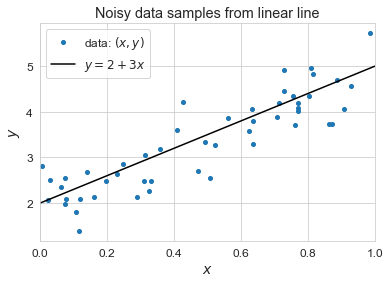

In [3]:
# Define the data
np.random.seed(42)
# Generate random data
n = 50 # Number of samples
# Underlying linear relation
m = 3  # slope
b = 2  # bias
# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(n)  # Noise
# Features and output
x = np.random.uniform(0, 1, n)  # Independent variable x
y = x * m + b + err  # Dependent variable

# Show data
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o', ms=4, label='data: $(x,y)$')
plt.plot([0, 1], [b, m+b], 'k-', label=f'$y = {b:.0f} + {m:.0f}x$')
plt.xlim((0, 1))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Noisy data samples from linear line')
plt.legend()
plt.show()
#

---

## Метод наименьших квадратов ##

**Определение 1.** *Функция потерь* (loss function) &mdash; это неотрицательная функция $\mathcal{L}(a, x)$, характеризующая величину ошибки алгоритма $a$ на объекте $x$. Если $\mathcal{L}(a, x) = 0$, то ответ $a(x)$ называется *корректным*.

**Определение 2.** *Функционал качества* алгоритма $a$ на выборке $X^l$:

$$ Q(a,X^l) = \frac{1}{l} \sum_{i=1}^{l} \mathcal{L}(a, x_i). $$

Функционал Q называют также функционалом *средних потерь* или *эмпирическим риском*, так как он вычисляется по эмпирическим данным $(x_i, y_i)_{i=1}^l$.

В задачах регрессии люычно применяется квадратичная функция потерь $\mathcal{L}(a, x) = (a(x) − y^*(x))^2$ &mdash, функционал $Q$ в этом случае называется средней квадратичной ошибкой алгоритма $a$ на выборке $X^l$; .

Классический метод обучения, называемый *минимизацией эмпирического риска* (empirical risk minimization, ERM), заключается в том, чтобы найти в заданной модели $A$ алгоритм $a$, доставляющий минимальное значение функционалу качества $Q$ на заданной обучающей выборке $X^l$:

$$ \mu(X^l) = \underset{a \in A}{\mathrm{argmin}} Q(a, X^l). $$


В задаче восстановления регрессии с числовыми признаками и квадратичной функцией потерь метод минимизации
эмпирического риска есть ничто иное, как метод наименьших квадратов.

Пусть задана *модель регрессии* &mdash; параметрическое семейство функций $g(x,\alpha)$, где $\alpha \in \mathbb{R}^p$ &mdash; вектор параметров модели. Определим функционал качества аппроксимации целевой зависимости на выборке $X^l$ как сумму квадратов ошибок:

$$ Q(\alpha, X^l) = \sum_{i=1}^l \left( g(x_i, \alpha) - y_i \right)^2. $$

Обучение по *методу наименьших квадратов* (МНК) состоит в том, чтобы найти вектор параметров $\alpha^*$, при котором достигается минимум среднего квадрата ошибки на заданной обучающей выборке $X^l$:

$$ \alpha^* = \underset{\alpha \in \mathbb{R}^n}{\mathrm{argmin}} \, {Q(\alpha, X^l)}. $$

---

## Линейная регрессия ##

Линейная регрессия является одной из самых простых моделей машинного обучения. Есть мнение, что её даже не следует классифицировать как &laquo;машинное обучение&raquo;, потому что она слишком простая.
Тем не менее, простота делает её прекрасной отправной точкой для понимания более сложных методов. На этом занятии мы исследуем основы линейной регрессии и рассмотрим её вероятностную интерпретацию.

Пусть каждому объекту соответствует его признаковое описание $\left( f_1(x), \ldots, f_n(x)\right)$, где $f_j: X \rightarrow \mathbb{R}$ &mdash; числовые признаки, $j = 1, \ldots , n$. Линейной моделью регрессии называется линейная комбинация признаков с коэффициентами $\alpha \in \mathbb{R}^n$:

$$ g(x, \alpha) = \sum_{j=1}^n \alpha_j f_j(x). $$

Введём матричные обозначения: $F = \left( f_j(x_i) \right)_{l \times n}$ &mdash; матрица объекты–признаки;
$y = \left( y_i \right)_{l \times 1}$ &mdash; целевой вектор;
$\alpha = \left( \alpha_i \right)_{l \times 1}$ &mdash; вектор параметров.

В матричных обозначениях функционал $Q$ принимает вид

$$ Q(\alpha) = \left\Vert F\alpha - y \right\Vert^2. $$

Тогда задача поиска параметров регрессии может быть сформулирована так: 

$$ \alpha^* = \underset{\alpha \in \mathbb{R}^n}{\text{argmin}} \, {\left\Vert F\alpha - y \right\Vert^2}. $$

Запишем необходимое условие минимума в матричном виде:

$$ \frac{\delta Q(\alpha)}{\delta \alpha} = 2F^\top (F\alpha - y) = 0. $$

Отсюда следует $F^{\top} F \alpha = F^{\top}y$. Эта система линейных уравнений относительно $\alpha$ называется нормальной системой для задачи наименьших квадратов. Если матрица $F^{\top} F$ размера $n \times n$ невырождена, то решением нормальной системы является вектор

$$ \alpha^* = (F^{\top} F)^{-1} F^{\top} y = F^{+} y. $$

Матрица $F^{+} = (F^{\top} F)^{-1} F^{\top}$ называется *псевдообратной* для прямоугольной матрицы $F$.

### Полиномиальная регрессия ###

Рассмотрим *частный случай* линейной регрессии &mdash; полиномиальную регрессию.

В этом случае

$$ g(x, \alpha) = \sum_{j=1}^n \alpha_j p_j(x).$$

где $p(x) = \{1, x, \ldots, x^n\}$ &mdash; набор базисных полиномов, $\alpha = \{\alpha_0, \ldots, \alpha_n\}$ &mdash; набор искомых параметров.


Воспользуемся введёнными матричными обозначениями. В нашем случае

- $\alpha = [ \alpha_0, \alpha_1]$,
- $F = [(1, x_1), \ldots , (1, x_l)]$,
- $y = [y_1, \ldots, y_l]$.

Пример пример построения полиномиальной регрессии для наших данных приведён ниже.

In [4]:
# Ordinary least squares

# Stack X with ones to be fitted by vectorized methods such as OLS and gradient descent
F = np.vstack((np.ones_like(x), x)).T

# Fit parameters with OLS
Alpha = np.linalg.inv(F.T @ F) @ F.T @ y

# Function representing fitted line
f = lambda x: Alpha[0] + Alpha[1]*x

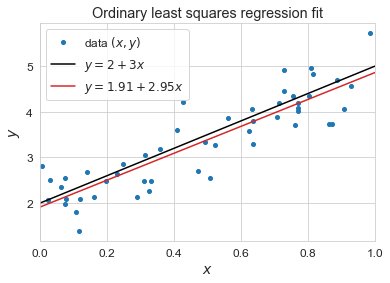

In [5]:
X = np.linspace(0, 1, 100)

# Show OLS fitted line
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o', ms=4, label='data $(x,y)$')
plt.plot([0, 1], [b, m+b], 'k-', label=f'$y = {b:.0f} + {m:.0f}x$')
plt.plot(X, f(X), '-', c=cm.tab10(3),
         label=f'$y = {Alpha[0]:.2f} + {Alpha[1]:.2f} x$')
plt.legend()
plt.title('Ordinary least squares regression fit')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim((0, 1))
plt.show()
#

---

## Вероятностная постановка задачи ##

В задачах обучения по прецедентам элементы множества X &mdash; это не реальные объекты, а лишь доступные данные о них.
Данные могут быть *неточными*, поскольку измерения значений признаков $f_j(x)$ и целевой зависимости $y^{*}(x)$ обычно выполняются с погрешностями.
Данные могут быть *неполными*, поскольку измеряются не все мыслимые признаки, а лишь физически доступные для измерения.
В результате одному и тому же описанию $x$ могут соответствовать различные объекты и различные ответы.
В таком случае $y^{*}(x)$, строго говоря, не является функцией.
Устранить эту некорректность позволяет *вероятностная постановка задачи*.

Вместо существования неизвестной целевой зависимости $y^{*}(x)$ предположим существование неизвестного вероятностного распределения на множестве $X \times Y$ с плотностью $p(x, y)$, из которого случайно и независимо выбираются $l$ наблюдений $X^l = (x_i, y_i)_{i=1}^l$.
Такие выборки называются *простыми* или *случайными одинаково распределёнными* (independent identically distributed, i.i.d.).

### Принцип максимума правдоподобия ###

При вероятностной постановке задачи вместо модели алгоритмов $g(x, \theta)$, аппроксимирующей неизвестную зависимость $y^{*}(x)$, задаётся модель совместной плотности распределения объектов и ответов $\varphi(x, y, \theta)$, аппроксимирующая неизвестную плотность $p(x, y)$.
Затем определяется значение параметра $\theta$, при котором выборка данных $X^l$ максимально правдоподобна, то есть наилучшим образом согласуется с моделью плотности.

Если наблюдения в выборке $X^l$ независимы, то совместная плотность распределения всех наблюдений равна произведению плотностей $p(x, y)$ в каждом наблюдении: $p(X^l) = p\left((x_1, y_1), \ldots , (x^l, y^l) \right) = p(x_1, y_1) \cdot \ldots \cdot p(x_l, y_l)$.
Подставляя вместо $p(x, y)$ модель плотности $\varphi(x, y, \theta)$, получаем *функцию правдоподобия* (likelihood):

$$ L(\theta,X^l) = \prod_{i=1}^l \varphi(x_i, y_i, \theta). $$

Чем выше значение правдоподобия, тем лучше выборка согласуется с моделью. Значит, нужно искать значение параметра $\theta$, при котором значение $L(\theta,X^l)$ максимально. В математической статистике это называется *принципом максимума правдоподобия*:

$$ \prod_{i=1}^l \varphi(x_i, y_i, \theta) \rightarrow \max_\alpha. $$

### Связь максимизации правдоподобия с минимизацией эмпирического риска ###

Вместо максимизации $L$ удобнее минимизировать функционал $-\ln L$, поскольку он аддитивен (имеет вид суммы) по объектам выборки:

$$ -\ln L(\theta,X^l) = - \sum_{i=1}^l \ln \varphi(x_i, y_i, \theta) \rightarrow \min_\theta. $$

Этот функционал совпадает с функционалом эмпирического риска, если определить вероятностную функцию потерь $\mathcal{L}(a_\theta, x) = - l \ln \varphi(x, y, \theta)$. Такое определение потери вполне естественно &mdash; чем хуже пара $(x_i, y_i)$ согласуется с моделью $\varphi$, тем меньше значение плотности $\varphi(x_i, y_i, \theta)$ и выше величина потери $\mathcal{L}(a_\theta, x)$.
Верно и обратное &mdash; для многих функций потерь возможно подобрать модель плотности $\varphi(x, y, \theta)$ таким образом, чтобы минимизация эмпирического риска была эквивалентна максимизации правдоподобия.

### Вероятностная интепретация метода наименьших квадратов ###

Предположим, что разности между моделью и истинными ответами (ошибки предсказания) можно считать независимыми нормально-рапределёнными случайными величинами с нулевым математическим ожиданием: 
$$
f(x_i, \alpha) - y(x_i) = \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2), \quad i=1, \ldots, l.
$$

Тогда, для функции правдоподобия, получим

$$
p(y \mid x, \alpha) = \prod_{i=1}^{n} p(y_i \mid x_i, \alpha) = 
\prod_{i=1}^{l} \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(f(x_i, \alpha) - y_i)^2}{2\sigma^2}\right)}.
$$

И, переходя к логарифму функции правдоподобия,

$$
\ln \left( \prod_{i=1}^{l} p(y_i \mid x_i, \alpha) \right) = -l \ln(\sqrt{2\pi\sigma^2}) - \frac{1}{2\sigma^2} \left[ \sum_{i=1}^{l} (y_i - (f(x_i, \alpha))^2 \right].
$$

Таким образом, методы наименьших квадратов и максимизации правдоподобия оказываются в данном случае эквивалентными.

---

## Задания ##
 - сделать регрессию полиномами со степенью $n>1$

## Дополнительный материал ##
- геометрическая интерпретация МНК, проекционная матрица
- сингулярное разложение
- гребневая регрессия
- лассо Тибширани

## Литература ##

1. Воронцов К.В. Математические методы обучения по прецендентам (теория обучения машин)
1. Roelants P. JNotebook &laquo;Multivariate-normal-primer.ipynb&raquo;

## Что сделать: ##
- добавить нелинейную регрессию или сделать по ней отдельный ноутбук

In [13]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.0
numpy: 1.15.2
matplotlib: 3.0.0
seaborn: 0.9.0


This post at <a rel="canonical" href="https://peterroelants.github.io/posts/linear-regression-four-ways/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/misc/linear-regression-four-ways.ipynb)